/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  10 of 10 completed


Covariance Matrix:
Ticker       1913.HK    BRBY.L    CDI.PA    CFR.SW        EL    KER.PA  \
Ticker                                                                   
1913.HK  4037.291176  0.087771  0.261585  0.217216  0.048877  0.084808   
BRBY.L      0.087771  0.109403  0.055009  0.057346  0.030419  0.054614   
CDI.PA      0.261585  0.055009  0.071980  0.056356  0.029529  0.055308   
CFR.SW      0.217216  0.057346  0.056356  0.090897  0.030783  0.056092   
EL          0.048877  0.030419  0.029529  0.030783  0.077854  0.029039   
KER.PA      0.084808  0.054614  0.055308  0.056092  0.029039  0.083410   
MC.PA       0.246865  0.055951  0.064038  0.058675  0.030890  0.058156   
RL         -0.312892  0.036345  0.034183  0.039865  0.043985  0.034144   
RMS.PA      0.007155  0.038973  0.041037  0.039846  0.019535  0.039890   
UHR.SW      0.321008  0.051077  0.049701  0.068971  0.027729  0.050414   

Ticker      MC.PA        RL    RMS.PA    UHR.SW  
Ticker                                    

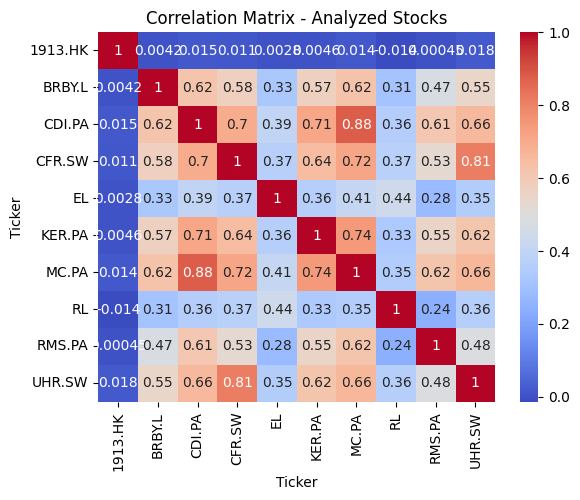

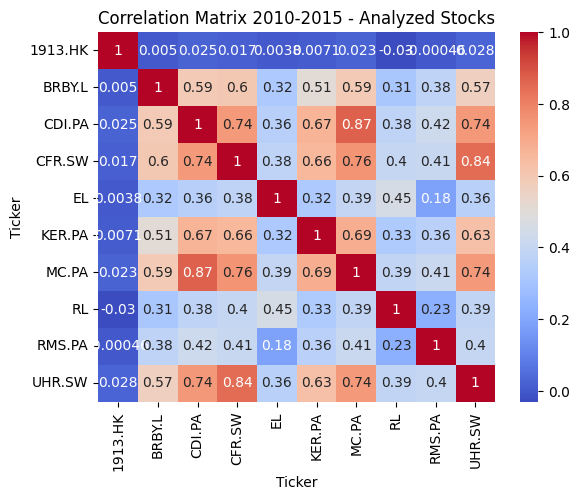

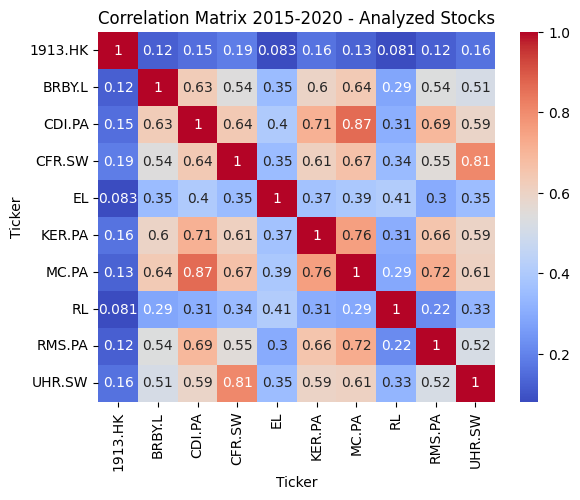

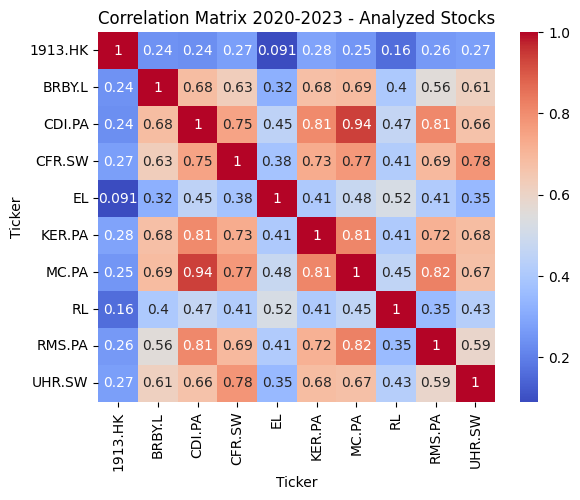

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def Correlation_analysis(tickers, start_date='2010-01-01', end_date='2023-01-01'):
    # Fetch the stock data
    stock_data = yf.download(tickers, start=start_date, end=end_date)['Close']

    # Function to compute returns
    def compute_return(prices):
        return prices.pct_change()

    # Compute returns for the stocks
    stock_returns = stock_data.apply(compute_return)

    # Drop NA values
    stock_returns = stock_returns.dropna()

    # Function to compute the covariance matrix
    def compute_covariance_matrix(returns, multiplicator=252):
        return returns.cov() * multiplicator

    # Function to compute the correlation matrix
    def compute_correlation_matrix(returns):
        return returns.corr()

    # Compute and print Covariance Matrix
    cov_matrix = compute_covariance_matrix(stock_returns)
    print("Covariance Matrix:")
    print(cov_matrix)

    # Compute and print Correlation Matrix
    corr_matrix = compute_correlation_matrix(stock_returns)
    print("\nCorrelation Matrix:")
    print(corr_matrix)

    # Visualization using Seaborn for the entire period
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix - Analyzed Stocks')
    plt.show()

    # Visualization for different time periods
    periods = {
        "2010-2015": ("2010-01-01", "2014-12-31"),
        "2015-2020": ("2015-01-01", "2020-12-31"),
        "2020-2023": ("2021-01-01", "2023-12-31")
    }

    for period, (start_date, end_date) in periods.items():
        temp_returns = stock_data[start_date:end_date].apply(compute_return)
        temp_corr_matrix = compute_correlation_matrix(temp_returns.dropna())
        sns.heatmap(temp_corr_matrix, annot=True, cmap='coolwarm')
        plt.title(f'Correlation Matrix {period} - Analyzed Stocks')
        plt.show()

# Example usage
luxury_tickers = [
    'MC.PA', 'KER.PA', 'CFR.SW', 'RMS.PA', 'BRBY.L', '1913.HK', 'EL', 'UHR.SW', 'RL', 'CDI.PA'
]

Correlation_analysis(luxury_tickers)


In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Function to identify the best correlated pair of stocks
def find_best_correlated_pair(stock_list, start_date='2020-01-01', end_date='2023-01-01'):
    max_corr = -1
    best_pair = None

    for i in range(len(stock_list)):
        for j in range(i + 1, len(stock_list)):
            try:
                stock_data = yf.download([stock_list[i], stock_list[j]], start=start_date, end=end_date)['Close']
                correlation = stock_data[stock_list[i]].corr(stock_data[stock_list[j]])

                if correlation > max_corr:
                    max_corr = correlation
                    best_pair = (stock_list[i], stock_list[j])
            except Exception as e:
                print(f"Error fetching data for {stock_list[i]} or {stock_list[j]}: {e}")
    print(best_pair)
    return best_pair

# Function to calculate the spread's Z-Score
def calculate_spread_zscore(best_pair, start_date='2020-01-01', end_date='2023-01-01', window=30):
    stock_data = yf.download(best_pair, start=start_date, end=end_date)['Close']

    # Calculate the spread
    spread = stock_data[best_pair[0]] - stock_data[best_pair[1]]

    # Calculate the rolling mean and standard deviation of the spread
    rolling_mean = spread.rolling(window=window).mean()
    rolling_std = spread.rolling(window=window).std()

    # Calculate the Z-Score
    z_score = (spread - rolling_mean) / rolling_std

    return z_score

# Function to go long on the spread
def go_long_on_spread(z_score, entry_threshold=-2):
    long_positions = z_score[z_score < entry_threshold]
    return long_positions

# Function to go short on the spread
def go_short_on_spread(z_score, entry_threshold=2):
    short_positions = z_score[z_score > entry_threshold]
    return short_positions

# Function to plot the signals for a single asset
def plot_asset_signals(stock_data, signals, asset_name):
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data.index, stock_data['Close'], label=f'{asset_name} Stock Prices', alpha=0.5)
    plt.scatter(signals.index, stock_data['Close'][signals.index], marker='^', color='g', label=f'Go Long ({asset_name})', alpha=1)
    plt.title(f'Go Long Signals for {asset_name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Using the functions
luxury_tickers = ['MC.PA', 'KER.PA', 'CFR.SW', 'RMS.PA', 'BRBY.L', '1913.HK', 'EL', 'UHR.SW', 'RL', 'CDI.PA']
best_correlated_pair = find_best_correlated_pair(luxury_tickers)
z_score = calculate_spread_zscore(best_correlated_pair)
long_positions = go_long_on_spread(z_score)
short_positions = go_short_on_spread(z_score)

# Separate plots for each asset
for asset in best_correlated_pair:
    try:
        asset_data = yf.download(asset, start='2020-01-01', end='2023-01-01')
        asset_signals = long_positions[asset]
        plot_asset_signals(asset_data, asset_signals, asset)
    except Exception as e:
        print(f"Error plotting signals for {asset}: {e}")


[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  2 of 2 completed
[*********************100%%*******

('MC.PA', 'CDI.PA')
Error plotting signals for MC.PA: 'MC.PA'
Error plotting signals for CDI.PA: 'CDI.PA'


[*********************100%%**********************]  2 of 2 completed


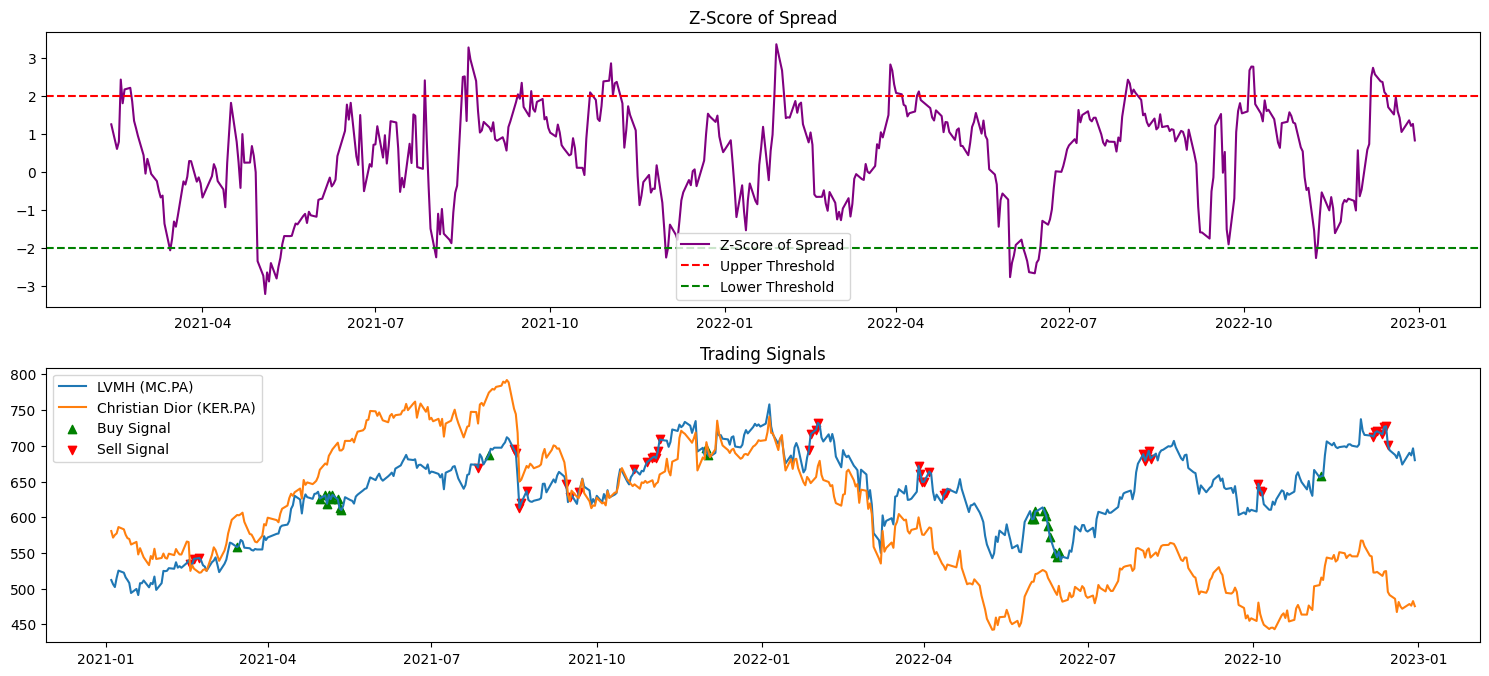

Final return from the strategy:  1521.9997253417969


In [7]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Download stock data for LVMH and Christian Dior
start_date = '2021-01-01'
end_date = '2023-01-01'
stock_symbols = ['MC.PA', 'KER.PA']  # MC.PA for LVMH and CDI.PA for Christian Dior
stock_data = yf.download(stock_symbols, start=start_date, end=end_date)['Close']

# Calculate the spread
spread = stock_data['MC.PA'] - stock_data['KER.PA']

# Calculate the rolling mean and standard deviation of the spread
window = 30
rolling_mean = spread.rolling(window=window).mean()
rolling_std = spread.rolling(window=window).std()

# Calculate the Z-Score
z_score = (spread - rolling_mean) / rolling_std

# Define thresholds for trading signals
upper_threshold = 2
lower_threshold = -2

# Generate trading signals
buy_signal = (z_score < lower_threshold)
sell_signal = (z_score > upper_threshold)

# Calculate returns - assuming we buy one stock of MC.PA and sell one stock of CDI.PA when a buy signal is generated, and vice versa for sell signals
capital = 10000  # Starting capital
mc_stocks = 0
cdi_stocks = 0

for i in range(len(z_score)):
    if buy_signal[i] and capital >= stock_data['MC.PA'].iloc[i]:
        # Buy MC.PA and sell CDI.PA
        mc_stocks += 1
        cdi_stocks -= 1
        capital -= stock_data['MC.PA'].iloc[i]
        capital += stock_data['KER.PA'].iloc[i]
    elif sell_signal[i] and mc_stocks > 0:
        # Sell MC.PA and buy CDI.PA
        mc_stocks -= 1
        cdi_stocks += 1
        capital += stock_data['MC.PA'].iloc[i]
        capital -= stock_data['KER.PA'].iloc[i]

# Final capital after selling any remaining stocks
capital += mc_stocks * stock_data['MC.PA'].iloc[-1]
capital += -cdi_stocks * stock_data['KER.PA'].iloc[-1]
final_return = capital - 10000

# Plotting
plt.figure(figsize=(15, 10))

# Plot Z-Score
plt.subplot(3, 1, 2)
plt.plot(z_score, label='Z-Score of Spread', color='purple')
plt.axhline(upper_threshold, color='red', linestyle='--', label='Upper Threshold')
plt.axhline(lower_threshold, color='green', linestyle='--', label='Lower Threshold')
plt.title('Z-Score of Spread')
plt.legend()

# Plot Buy/Sell Signals
plt.subplot(3, 1, 3)
plt.plot(stock_data['MC.PA'], label='LVMH (MC.PA)')
plt.plot(stock_data['KER.PA'], label='Christian Dior (KER.PA)')
plt.scatter(stock_data['MC.PA'].loc[buy_signal].index, stock_data['MC.PA'].loc[buy_signal], label='Buy Signal', marker='^', color='green')
plt.scatter(stock_data['MC.PA'].loc[sell_signal].index, stock_data['MC.PA'].loc[sell_signal], label='Sell Signal', marker='v', color='red')
plt.title('Trading Signals')
plt.legend()

plt.tight_layout()
plt.show()

print("Final return from the strategy: ", final_return)


[*********************100%%**********************]  2 of 2 completed


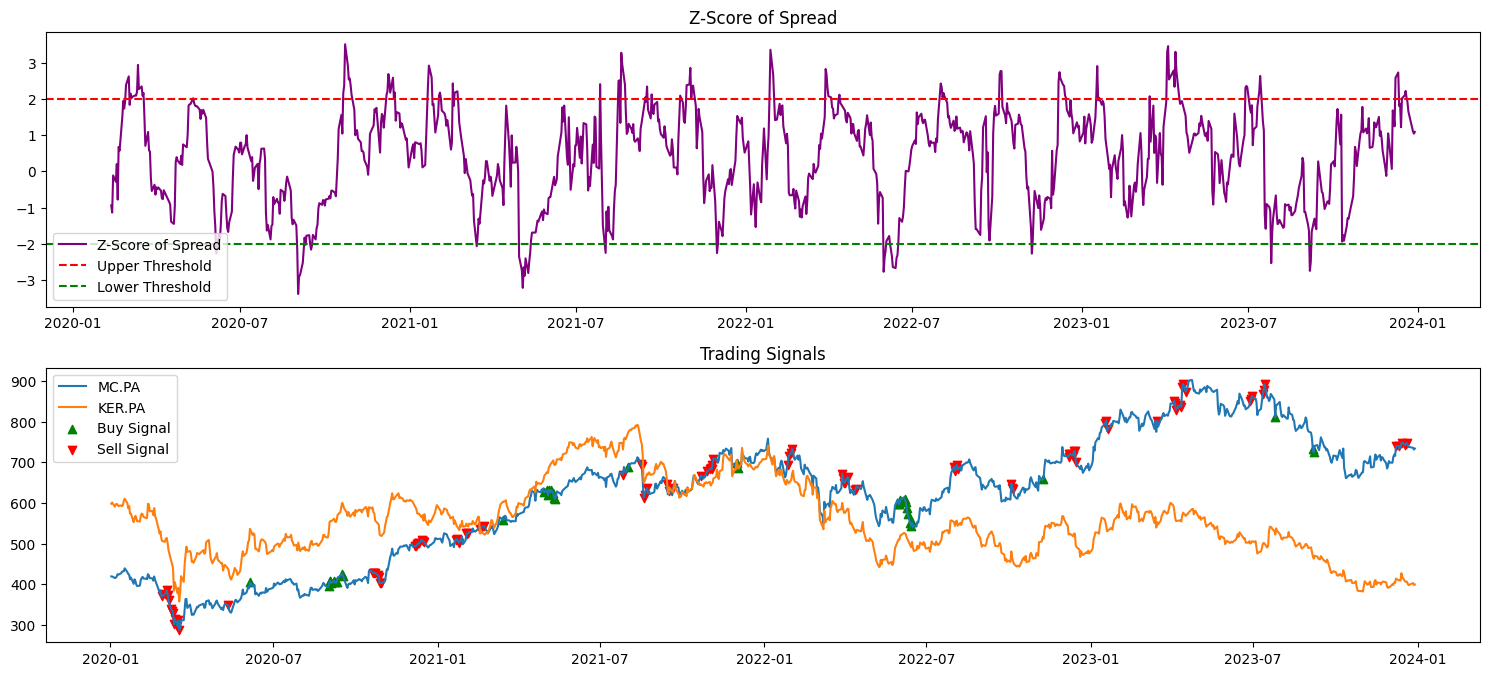

BUY MC.PA at price 404.25 on date 2020-06-05 00:00:00
SELL KER.PA at price 536.0999755859375 on date 2020-06-05 00:00:00
BUY MC.PA at price 396.70001220703125 on date 2020-09-01 00:00:00
SELL KER.PA at price 525.0 on date 2020-09-01 00:00:00
BUY MC.PA at price 407.25 on date 2020-09-02 00:00:00
SELL KER.PA at price 553.0 on date 2020-09-02 00:00:00
BUY MC.PA at price 408.3999938964844 on date 2020-09-03 00:00:00
SELL KER.PA at price 555.2999877929688 on date 2020-09-03 00:00:00
BUY MC.PA at price 402.8500061035156 on date 2020-09-04 00:00:00
SELL KER.PA at price 555.0 on date 2020-09-04 00:00:00
BUY MC.PA at price 408.79998779296875 on date 2020-09-07 00:00:00
SELL KER.PA at price 561.0 on date 2020-09-07 00:00:00
BUY MC.PA at price 404.3999938964844 on date 2020-09-08 00:00:00
SELL KER.PA at price 555.0 on date 2020-09-08 00:00:00
BUY MC.PA at price 404.3500061035156 on date 2020-09-10 00:00:00
SELL KER.PA at price 559.4000244140625 on date 2020-09-10 00:00:00
BUY MC.PA at price 426.1

In [15]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

def pair_trading_strategy(stock_symbols, start_date, end_date, window=30, upper_threshold=2, lower_threshold=-2, capital=10000):
    # Download stock data
    stock_data = yf.download(stock_symbols, start=start_date, end=end_date)['Close']

    # Calculate the spread
    spread = stock_data[stock_symbols[0]] - stock_data[stock_symbols[1]]

    # Calculate the rolling mean and standard deviation of the spread
    rolling_mean = spread.rolling(window=window).mean()
    rolling_std = spread.rolling(window=window).std()

    # Calculate the Z-Score
    z_score = (spread - rolling_mean) / rolling_std

    # Generate trading signals
    buy_signal = (z_score < lower_threshold)
    sell_signal = (z_score > upper_threshold)

    # Simulate trading
    mc_stocks = 0
    cdi_stocks = 0
    trades = []

    for i in range(len(z_score)):
        if buy_signal[i] and capital >= stock_data[stock_symbols[0]].iloc[i]:
            mc_stocks += 1
            cdi_stocks -= 1
            capital -= stock_data[stock_symbols[0]].iloc[i]
            capital += stock_data[stock_symbols[1]].iloc[i]
            trades.append(('BUY', stock_symbols[0], stock_data[stock_symbols[0]].iloc[i], stock_data.index[i]))
            trades.append(('SELL', stock_symbols[1], stock_data[stock_symbols[1]].iloc[i], stock_data.index[i]))
        elif sell_signal[i] and mc_stocks > 0:
            mc_stocks -= 1
            cdi_stocks += 1
            capital += stock_data[stock_symbols[0]].iloc[i]
            capital -= stock_data[stock_symbols[1]].iloc[i]
            trades.append(('SELL', stock_symbols[0], stock_data[stock_symbols[0]].iloc[i], stock_data.index[i]))
            trades.append(('BUY', stock_symbols[1], stock_data[stock_symbols[1]].iloc[i], stock_data.index[i]))

    # Final capital after selling any remaining stocks
    capital += mc_stocks * stock_data[stock_symbols[0]].iloc[-1]
    capital += -cdi_stocks * stock_data[stock_symbols[1]].iloc[-1]
    final_return = capital - 10000

    # Plotting
    plt.figure(figsize=(15, 10))

    # Plot Z-Score
    plt.subplot(3, 1, 2)
    plt.plot(z_score, label='Z-Score of Spread', color='purple')
    plt.axhline(upper_threshold, color='red', linestyle='--', label='Upper Threshold')
    plt.axhline(lower_threshold, color='green', linestyle='--', label='Lower Threshold')
    plt.title('Z-Score of Spread')
    plt.legend()

    # Plot Buy/Sell Signals
    plt.subplot(3, 1, 3)
    plt.plot(stock_data[stock_symbols[0]], label=f'{stock_symbols[0]}')
    plt.plot(stock_data[stock_symbols[1]], label=f'{stock_symbols[1]}')
    plt.scatter(stock_data[stock_symbols[0]].loc[buy_signal].index, stock_data[stock_symbols[0]].loc[buy_signal], label='Buy Signal', marker='^', color='green')
    plt.scatter(stock_data[stock_symbols[0]].loc[sell_signal].index, stock_data[stock_symbols[0]].loc[sell_signal], label='Sell Signal', marker='v', color='red')
    plt.title('Trading Signals')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return trades, final_return

# Define parameters
stock_symbols = ['MC.PA', 'KER.PA']  # Tickers for LVMH and Kering
start_date = '2020-01-01'
end_date = '2023-12-31'

# Run the trading strategy function
trades, final_return = pair_trading_strategy(stock_symbols, start_date, end_date)

# Print the trades and final return
for trade in trades:
    print(f"{trade[0]} {trade[1]} at price {trade[2]} on date {trade[3]}")

print("Final return from the strategy: ", final_return)


[*********************100%%**********************]  2 of 2 completed


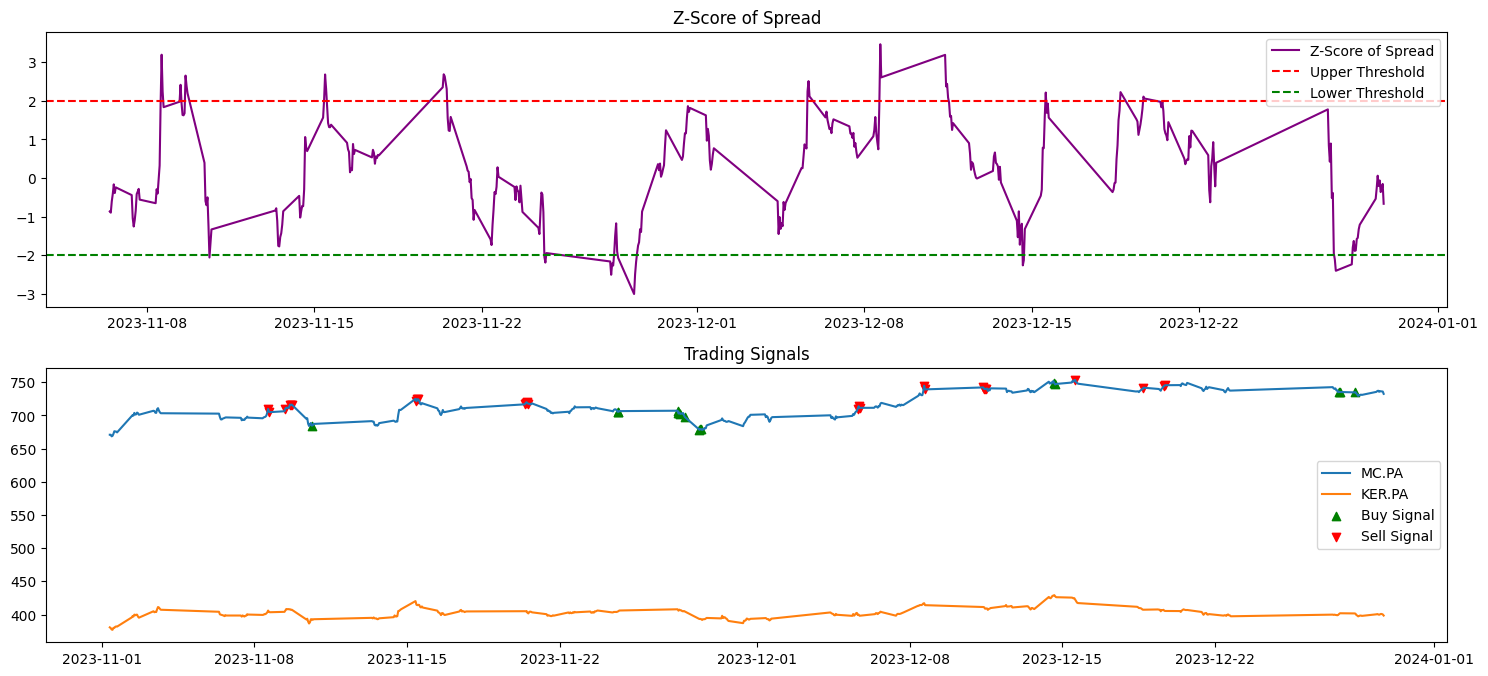

BUY MC.PA at price 684.7999877929688 on date 2023-11-10 15:00:00+01:00 - Number of shares: 10
SELL MC.PA at price 721.5 on date 2023-11-15 10:00:00+01:00 - Number of shares: 10
BUY MC.PA at price 705.7999877929688 on date 2023-11-24 15:00:00+01:00 - Number of shares: 10
SELL MC.PA at price 710.2000122070312 on date 2023-12-05 15:00:00+01:00 - Number of shares: 10
BUY MC.PA at price 748.5999755859375 on date 2023-12-14 15:00:00+01:00 - Number of shares: 10
SELL MC.PA at price 753.4000244140625 on date 2023-12-15 14:00:00+01:00 - Number of shares: 10
BUY MC.PA at price 735.7000122070312 on date 2023-12-27 16:00:00+01:00 - Number of shares: 10
Final return from the strategy:  428.00048828125


In [62]:
import yfinance as yf
import matplotlib.pyplot as plt

def pair_trading_strategy(stock_symbols, start_date, end_date, window=30, upper_threshold=2, lower_threshold=-2, initial_investment=10000,interval='1d'):
    # Download stock data
    stock_data = yf.download(stock_symbols, start=start_date, end=end_date,interval=interval)['Close']

    # Calculate the spread
    spread = stock_data[stock_symbols[0]] - stock_data[stock_symbols[1]]

    # Calculate the rolling mean and standard deviation of the spread
    rolling_mean = spread.rolling(window=window).mean()
    rolling_std = spread.rolling(window=window).std()

    # Calculate the Z-Score
    z_score = (spread - rolling_mean) / rolling_std

    # Generate trading signals
    buy_signal = (z_score < lower_threshold)
    sell_signal = (z_score > upper_threshold)

    # Initialize variables for trading simulation
    cash = initial_investment
    shares_held = 0
    trades = []

    # Simulate trading
    for i in range(len(z_score)):
        if buy_signal[i] and cash >= stock_data[stock_symbols[0]].iloc[i] * 10 and shares_held == 0:
            # Buy 10 shares
            shares_held = 10
            cash -= shares_held * stock_data[stock_symbols[0]].iloc[i]
            trades.append(('BUY', stock_symbols[0], stock_data[stock_symbols[0]].iloc[i], stock_data.index[i], shares_held))

        elif sell_signal[i] and shares_held > 0:
            # Sell all shares
            cash += shares_held * stock_data[stock_symbols[0]].iloc[i]
            trades.append(('SELL', stock_symbols[0], stock_data[stock_symbols[0]].iloc[i], stock_data.index[i], shares_held))
            shares_held = 0

    # Final portfolio value
    final_portfolio_value = cash + shares_held * stock_data[stock_symbols[0]].iloc[-1]
    final_return = final_portfolio_value - initial_investment

    # Plotting
    plt.figure(figsize=(15, 10))

    # Plot Z-Score
    plt.subplot(3, 1, 2)
    plt.plot(z_score, label='Z-Score of Spread', color='purple')
    plt.axhline(upper_threshold, color='red', linestyle='--', label='Upper Threshold')
    plt.axhline(lower_threshold, color='green', linestyle='--', label='Lower Threshold')
    plt.title('Z-Score of Spread')
    plt.legend()

    # Plot Buy/Sell Signals
    plt.subplot(3, 1, 3)
    plt.plot(stock_data[stock_symbols[0]], label=f'{stock_symbols[0]}')
    plt.plot(stock_data[stock_symbols[1]], label=f'{stock_symbols[1]}')
    plt.scatter(stock_data[stock_symbols[0]].loc[buy_signal].index, stock_data[stock_symbols[0]].loc[buy_signal], label='Buy Signal', marker='^', color='green')
    plt.scatter(stock_data[stock_symbols[0]].loc[sell_signal].index, stock_data[stock_symbols[0]].loc[sell_signal], label='Sell Signal', marker='v', color='red')
    plt.title('Trading Signals')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return trades, final_return

# Define parameters and run the strategy
stock_symbols = ['MC.PA', 'KER.PA']
start_date = '2023-11-01'
end_date = '2023-12-31'

interval = '1h'  # Set interval to 1 hour

trades, final_return = pair_trading_strategy(stock_symbols, start_date, end_date, interval=interval)

# Print the trades and final return
for trade in trades:
    print(f"{trade[0]} {trade[1]} at price {trade[2]} on date {trade[3]} - Number of shares: {trade[4]}")

print("Final return from the strategy: ", final_return)


[*********************100%%**********************]  2 of 2 completed


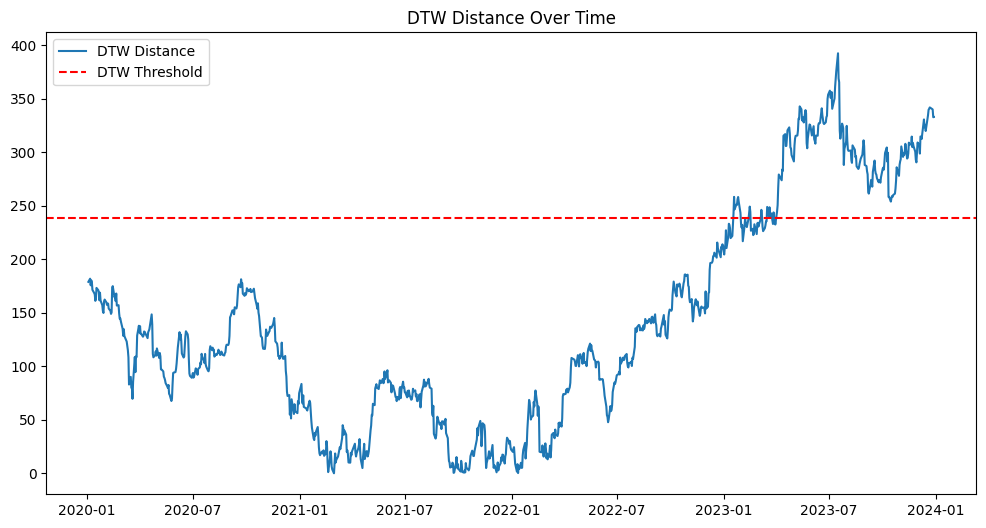

In [13]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

def dtw_distance_calculation(ts1, ts2):
    n, m = len(ts1), len(ts2)
    dtw_matrix = np.zeros((n+1, m+1))
    dtw_matrix[0, :] = np.inf
    dtw_matrix[:, 0] = np.inf
    dtw_matrix[0, 0] = 0

    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(ts1[i-1] - ts2[j-1])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1])

    return dtw_matrix[n, m]

# Function to calculate threshold based on historical DTW distances
def calculate_dtw_threshold(dtw_distances):
    mean_dtw = np.mean(dtw_distances)
    std_dtw = np.std(dtw_distances)
    return mean_dtw + std_dtw

def simulate_pair_trading_with_dtw(stock_symbols, start_date, end_date, window):
    stock_data = yf.download(stock_symbols, start=start_date, end=end_date)['Close']
    spread = stock_data[stock_symbols[0]] - stock_data[stock_symbols[1]]

    # Calculate DTW distances over a rolling window
    dtw_distances = []
    for i in range(window, len(spread)):
        ts1 = stock_data[stock_symbols[0]][i-window:i]
        ts2 = stock_data[stock_symbols[1]][i-window:i]
        dtw_distance = dtw_distance_calculation(ts1, ts2)
        dtw_distances.append(dtw_distance)

    # Calculate threshold
    dtw_threshold = calculate_dtw_threshold(dtw_distances)

    # Plot the DTW distances and threshold
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data.index[window:], dtw_distances, label='DTW Distance')
    plt.axhline(dtw_threshold, color='red', linestyle='--', label='DTW Threshold')
    plt.legend()
    plt.title('DTW Distance Over Time')
    plt.show()

    # Volatility adjustment (if needed)
    # Adjust the DTW threshold based on the pair's volatility
    volatility = np.std(spread)
    dtw_threshold *= volatility / np.mean(volatility)

    return dtw_distances, dtw_threshold

# Example usage
stock_symbols = ['MC.PA', 'KER.PA']
start_date = '2020-01-01'
end_date = '2023-12-31'
window = 1

dtw_distances, dtw_threshold = simulate_pair_trading_with_dtw(stock_symbols, start_date, end_date, window)



In [21]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Function to simulate the pair trading strategy
def simulate_pair_trading(stock_symbols, start_date, end_date, capital, upper_threshold, lower_threshold, window):
    # Download stock data
    stock_data = yf.download(stock_symbols, start=start_date, end=end_date)['Close']

    # Calculate the spread
    spread = stock_data[stock_symbols[0]] - stock_data[stock_symbols[1]]

    # Calculate the rolling mean and standard deviation of the spread
    rolling_mean = spread.rolling(window=window).mean()
    rolling_std = spread.rolling(window=window).std()

    # Calculate the Z-Score
    z_score = (spread - rolling_mean) / rolling_std

    # Generate trading signals
    buy_signal = (z_score < lower_threshold)
    sell_signal = (z_score > upper_threshold)

    # Initialize variables to track the trades and returns
    trades = []
    mc_stocks = 0
    cdi_stocks = 0

    # Simulate the trading strategy
    for i in range(len(z_score)):
        date = stock_data.index[i]
        if buy_signal[i] and capital >= stock_data[stock_symbols[0]].iloc[i]:
            # Buy MC.PA and sell CDI.PA
            mc_stocks += 1
            cdi_stocks -= 1
            capital -= stock_data[stock_symbols[0]].iloc[i]
            capital += stock_data[stock_symbols[1]].iloc[i]
            trades.append(("BUY", stock_symbols[0], stock_data[stock_symbols[0]].iloc[i], date))
            trades.append(("SELL", stock_symbols[1], stock_data[stock_symbols[1]].iloc[i], date))
        elif sell_signal[i] and mc_stocks > 0:
            # Sell MC.PA and buy CDI.PA
            mc_stocks -= 1
            cdi_stocks += 1
            capital += stock_data[stock_symbols[0]].iloc[i]
            capital -= stock_data[stock_symbols[1]].iloc[i]
            trades.append(("SELL", stock_symbols[0], stock_data[stock_symbols[0]].iloc[i], date))
            trades.append(("BUY", stock_symbols[1], stock_data[stock_symbols[1]].iloc[i], date))

    # Final capital after selling any remaining stocks
    capital += mc_stocks * stock_data[stock_symbols[0]].iloc[-1]
    capital += -cdi_stocks * stock_data[stock_symbols[1]].iloc[-1]
    final_return = capital - 10000

    return trades, final_return

# Define parameters
stock_symbols = ['MC.PA', 'CDI.PA']
start_date = '2021-01-01'
end_date = '2023-01-01'
capital = 10000
upper_threshold = 2
lower_threshold = -2
window = 30

# Run the trading simulation
trades, final_return = simulate_pair_trading(stock_symbols, start_date, end_date, capital, upper_threshold, lower_threshold, window)

# Print the trades
for trade in trades:
    print(f"{trade[0]} {trade[1]} at {trade[2]} on {trade[3]}")

# Print the final return
print("Final return from the strategy: ", final_return)


[*********************100%%**********************]  2 of 2 completed

BUY MC.PA at 543.7999877929688 on 2021-03-03 00:00:00
SELL CDI.PA at 486.20001220703125 on 2021-03-03 00:00:00
BUY MC.PA at 533.9000244140625 on 2021-03-04 00:00:00
SELL CDI.PA at 480.20001220703125 on 2021-03-04 00:00:00
BUY MC.PA at 523.2000122070312 on 2021-03-05 00:00:00
SELL CDI.PA at 469.6000061035156 on 2021-03-05 00:00:00
BUY MC.PA at 616.7000122070312 on 2021-04-15 00:00:00
SELL CDI.PA at 577.0 on 2021-04-15 00:00:00
BUY MC.PA at 630.0 on 2021-04-16 00:00:00
SELL CDI.PA at 591.0 on 2021-04-16 00:00:00
BUY MC.PA at 624.9000244140625 on 2021-04-19 00:00:00
SELL CDI.PA at 590.5 on 2021-04-19 00:00:00
BUY MC.PA at 624.5999755859375 on 2021-04-21 00:00:00
SELL CDI.PA at 594.0 on 2021-04-21 00:00:00
BUY MC.PA at 632.0 on 2021-04-22 00:00:00
SELL CDI.PA at 604.5 on 2021-04-22 00:00:00
BUY MC.PA at 628.0999755859375 on 2021-04-23 00:00:00
SELL CDI.PA at 604.0 on 2021-04-23 00:00:00
BUY MC.PA at 625.7999877929688 on 2021-04-26 00:00:00
SELL CDI.PA at 598.5 on 2021-04-26 00:00:00
BUY MC

[*********************100%%**********************]  2 of 2 completed


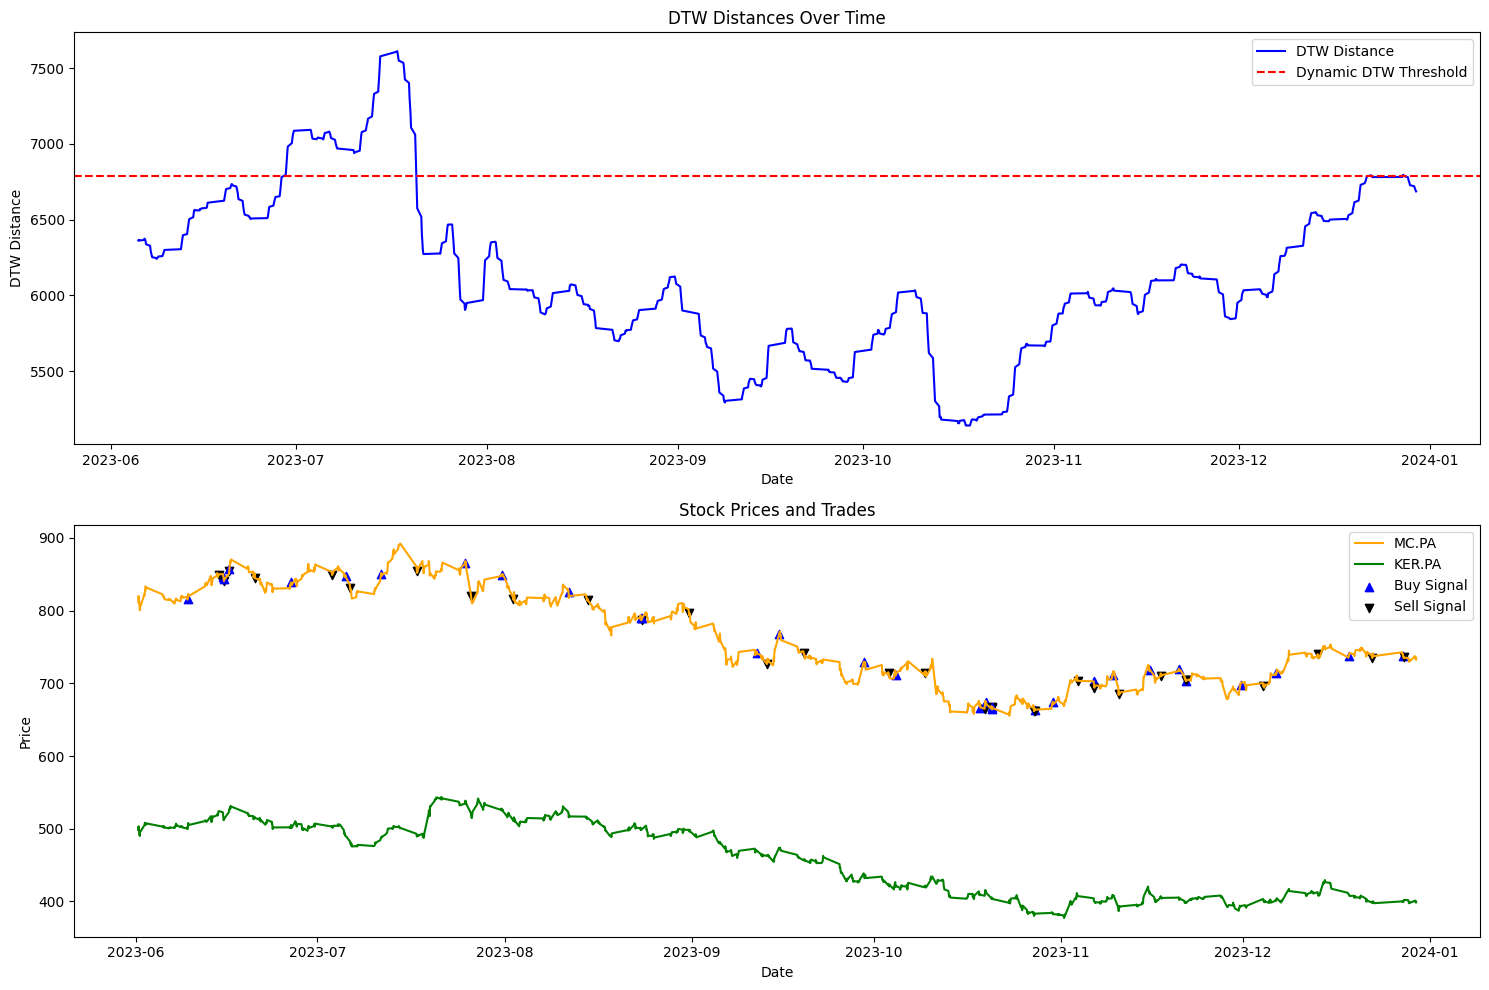

BUY MC.PA at price 816.5 on date 2023-06-09 14:00:00+02:00 - Number of shares: 10
SELL MC.PA at price 849.2999877929688 on date 2023-06-14 16:00:00+02:00 - Number of shares: 10
BUY MC.PA at price 845.7999877929688 on date 2023-06-15 11:00:00+02:00 - Number of shares: 10
SELL MC.PA at price 840.5999755859375 on date 2023-06-15 13:00:00+02:00 - Number of shares: 10
BUY MC.PA at price 843.0999755859375 on date 2023-06-15 15:00:00+02:00 - Number of shares: 10
SELL MC.PA at price 854.0 on date 2023-06-16 10:00:00+02:00 - Number of shares: 10
BUY MC.PA at price 857.4000244140625 on date 2023-06-16 11:00:00+02:00 - Number of shares: 10
SELL MC.PA at price 845.5999755859375 on date 2023-06-20 16:00:00+02:00 - Number of shares: 10
BUY MC.PA at price 838.7999877929688 on date 2023-06-26 15:00:00+02:00 - Number of shares: 10
SELL MC.PA at price 849.0 on date 2023-07-03 11:00:00+02:00 - Number of shares: 10
BUY MC.PA at price 847.4000244140625 on date 2023-07-05 16:00:00+02:00 - Number of shares: 

In [49]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

def dtw_distance_calculation(ts1, ts2):
    n, m = len(ts1), len(ts2)
    dtw_matrix = np.zeros((n+1, m+1))
    dtw_matrix[0, :] = np.inf
    dtw_matrix[:, 0] = np.inf
    dtw_matrix[0, 0] = 0

    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(ts1[i-1] - ts2[j-1])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1])

    return dtw_matrix[n, m]

def pair_trading_strategy_dtw(stock_symbols, start_date, end_date, window=20, percentile=95, initial_investment=10000, interval='1d'):
    # Download stock data
    stock_data = yf.download(stock_symbols, start=start_date, end=end_date, interval=interval)['Close']

    # Initialize variables for trading simulation
    cash = initial_investment
    shares_held = 0
    trades = []
    dtw_distances = []

    # Simulate trading using DTW
    for i in range(window, len(stock_data)):
        ts1 = stock_data[stock_symbols[0]][i-window:i]
        ts2 = stock_data[stock_symbols[1]][i-window:i]
        distance = dtw_distance_calculation(ts1, ts2)
        dtw_distances.append(distance)

        # Dynamically calculate the DTW threshold based on the historical data
        if len(dtw_distances) >= window:
            dtw_threshold = np.percentile(dtw_distances[-window:], percentile)

            # Buy signal: DTW distance exceeds the threshold
            if distance > dtw_threshold and cash >= stock_data[stock_symbols[0]].iloc[i] * 10 and shares_held == 0:
                # Buy 10 shares
                shares_held = 10
                cash -= shares_held * stock_data[stock_symbols[0]].iloc[i]
                trades.append(('BUY', stock_symbols[0], stock_data[stock_symbols[0]].iloc[i], stock_data.index[i], shares_held))

            # Sell signal: DTW distance falls below the threshold
            elif distance < dtw_threshold and shares_held > 0:
                # Sell all shares
                cash += shares_held * stock_data[stock_symbols[0]].iloc[i]
                trades.append(('SELL', stock_symbols[0], stock_data[stock_symbols[0]].iloc[i], stock_data.index[i], shares_held))
                shares_held = 0

    # Final portfolio value
    final_portfolio_value = cash + shares_held * stock_data[stock_symbols[0]].iloc[-1]
    final_return = final_portfolio_value - initial_investment

    # Plotting
    plt.figure(figsize=(15, 10))

    # Plot DTW Distances
    plt.subplot(2, 1, 1)
    plt.plot(stock_data.index[window:], dtw_distances, label='DTW Distance', color='blue')
    plt.axhline(dtw_threshold, color='red', linestyle='--', label='Dynamic DTW Threshold')
    plt.title('DTW Distances Over Time')
    plt.xlabel('Date')
    plt.ylabel('DTW Distance')
    plt.legend()

    # Plot Trades
    plt.subplot(2, 1, 2)
    plt.plot(stock_data[stock_symbols[0]], label=stock_symbols[0], color='orange')
    plt.plot(stock_data[stock_symbols[1]], label=stock_symbols[1], color='green')

    # Mark the trades on the plot
    for trade in trades:
        if trade[0] == 'BUY':
            plt.scatter(trade[3], trade[2], marker='^', color='blue', label='Buy Signal' if 'Buy Signal' not in plt.gca().get_legend_handles_labels()[1] else "")
        elif trade[0] == 'SELL':
            plt.scatter(trade[3], trade[2], marker='v', color='black', label='Sell Signal' if 'Sell Signal' not in plt.gca().get_legend_handles_labels()[1] else "")

    plt.title('Stock Prices and Trades')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return trades, final_return, dtw_distances

# Define parameters and run the strategy
stock_symbols = ['MC.PA', 'KER.PA']
start_date = '2023-06-01'
end_date = '2023-12-31'

interval = '1h'  # Set interval to 1 hour

trades, final_return, dtw_distances = pair_trading_strategy_dtw(stock_symbols, start_date, end_date, interval=interval )

# Print the trades and final return
for trade in trades:
    print(f"{trade[0]} {trade[1]} at price {trade[2]} on date {trade[3]} - Number of shares: {trade[4]}")

print("Final return from the strategy: ", final_return)
